In [1]:
%load_ext autoreload

In [23]:
%autoreload 2

import copy
import dataclasses
import functools
import gc
import itertools
import logging
import operator
import pprint as pprint_module
import time
from functools import partial
from pathlib import Path

import humanize
import numpy as np
import tensorflow as tf
from cnn_segm import keras_custom_loss
from matplotlib import pyplot as plt
from numpy.random import RandomState
from progressbar import progressbar as pbar
from pymicro.file import file_utils
import socket
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tomo2seg.process import ProcessVolumeArgs as Args, reduce_dimensions 
from tomo2seg import viz
from tomo2seg.data import EstimationVolume
from tomo2seg.data import Volume
from tomo2seg.logger import add_file_handler as logger_add_file_handler
from tomo2seg.logger import logger
from tomo2seg.model import Model as Tomo2SegModel
from tomo2seg import utils as tomo2seg_utils

# Args

In [3]:
!find ../data/models -maxdepth 1 -type d -exec ls "{}" \; | grep -v hdf5 
# print all available models' names

unet2d
unet2d-sep
unet2halfd
unet2halfd-sep
unet3d
unet2d.crop112-f16.fold000.1607-533-765
unet2d.crop48-f16.fold000.1607-530-580
unet2d.vanilla01-f04.fold000.1606-326-760
unet2d.vanilla01-f08.fold000.1606-377-881
unet2d.vanilla01-f16.fold000.1606-391-447
unet2d.vanilla02-f04.fold000.1606-419-966
unet2d.vanilla02-f08.fold000.1606-431-664
unet2d.vanilla02-f16.fold000.1606-461-820
unet2d.vanilla03-f16.fold000.1606-505-109
unet2halfd.vanilla00-f02.fold000.1606-654-198
unet2halfd.vanilla00-f04.fold000.1606-680-413
unet2halfd.vanilla03-f16.fold000.1606-683-705
unet3d.crop112-f12.fold000.1607-466-349
unet3d.crop96-f08.fold000.1607-109-265
unet3d.vanilla03-f08.fold000.1606-842-005
unet3d.vanilla03-f16.fold000.1606-750-939
unet2halfd-sep.vanilla03-f16.fold000.1606-729-672
unet2d-sep.vanilla03-f16.fold000.1606-575-226


In [7]:
from tomo2seg.datasets import (
    VOLUME_COMPOSITE_V1 as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_V1_REDUCED as VOLUME_NAME_VERSION,
#     VOLUME_COMPOSITE_NEIGHBOUR as VOLUME_NAME_VERSION,    
#     VOLUME_COMPOSITE_FLEX as VOLUME_NAME_VERSION,    
#     VOLUME_COMPOSITE_BIAXE as VOLUME_NAME_VERSION,    
)


args = Args(
    model_name = "unet2halfd.vanilla03-f16.fold000.1606-683-705",
    model_type = Args.ModelType.input2halfd, 
    
    model_shape_min_multiple_requirement = 16,
    
    volume_name=VOLUME_NAME_VERSION[0], 
    volume_version=VOLUME_NAME_VERSION[1], 
    
#     partition_alias=None,
    partition_alias="test",
    
    cropping_strategy=Args.CroppingStrategy.maximum_size_reduced_overlap, 
    aggregation_strategy=Args.AggregationStrategy.average_probabilities, 
    
#     runid = 1607597156,  # default is time.time()
    probabilities_dtype = np.float16,
    
    opts=Args.ProcessVolumeOpts(
        save_probas_by_class = False,
        debug__save_figs = True,
        save_logs=True,
        override_batch_size=None,
    ), 
)

build `tomo2seg` objects 

In [8]:
tomo2seg_model = Tomo2SegModel.build_from_model_name(args.model_name)

volume = Volume.with_check(
    name=args.volume_name, 
    version=args.volume_version
)

partition = volume[args.partition_alias] if args.partition_alias is not None else None

estimation_volume = EstimationVolume.from_objects(
    volume=volume, 
    model=tomo2seg_model, 
    set_partition=partition,
    runid=args.runid,
)

if args.opts.save_logs:
    logger_add_file_handler(logger, estimation_volume.exec_log_path)

# this is informal metadata for human use
estimation_volume["args"] = dataclasses.asdict(args)
estimation_volume["hostname"] = hostname = socket.gethostname()

INFO::tomo2seg::{logger.py:add_file_handler:020}::[2020-12-10::17:13:04.665]
Added a new file handler to the logger. logspath='/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.exec.log'



show args

In [9]:
logger.info(f"args\n{pprint_module.PrettyPrinter(indent=4, compact=False).pformat(dataclasses.asdict(args))}")
logger.info(f"{estimation_volume=}")
logger.info(f"{estimation_volume.fullname=}")
logger.info(f"{estimation_volume.dir=}")

            
logger.debug(f"{volume=}")
logger.debug(f"{partition=}")
logger.debug(f"{tomo2seg_model=}")
logger.debug(f"{tomo2seg_model.name=}")

INFO::tomo2seg::{<ipython-input-9-4136882eb0f2>:<module>:001}::[2020-12-10::17:13:04.790]
args
{   'aggregation_strategy': <AggregationStrategy.average_probabilities: 0>,
    'cropping_strategy': <CroppingStrategy.maximum_size_reduced_overlap: 1>,
    'model_name': 'unet2halfd.vanilla03-f16.fold000.1606-683-705',
    'model_shape_min_multiple_requirement': 16,
    'model_type': <ModelType.input2halfd: 1>,
    'opts': {   'debug__save_figs': True,
                'override_batch_size': None,
                'save_logs': True,
                'save_probas_by_class': False},
    'partition_alias': 'test',
    'probabilities_dtype': <class 'numpy.float16'>,
    'random_state_seed': 42,
    'runid': 1607616782,
    'volume_name': 'PA66GF30',
    'volume_version': 'v1'}

INFO::tomo2seg::{<ipython-input-9-4136882eb0f2>:<module>:002}::[2020-12-10::17:13:04.791]
estimation_volume=EstimationVolume(volume_fullname='PA66GF30.v1', model_name='unet2halfd.vanilla03-f16.fold000.1606-683-705', runid=16

# Setup

In [10]:
logger.setLevel(logging.DEBUG)
random_state = np.random.RandomState(args.random_state_seed)

n_gpus = len(tf.config.list_physical_devices('GPU'))
estimation_volume["n_gpus"] = n_gpus
    
tf_version = tf.__version__
logger.info(f"{tf_version=}")
estimation_volume["tf_version"] = tf_version

logger.info(f"Num GPUs Available: {n_gpus}\nThis should be:\n\t" + '\n\t'.join(['2 on R790-TOMO', '1 on akela', '1 on hathi', '1 on krilin']))

logger.debug(
    "physical GPU devices:\n\t" + "\n\t".join(map(str, tf.config.list_physical_devices('GPU'))) + "\n" +
    "logical GPU devices:\n\t" + "\n\t".join(map(str, tf.config.list_logical_devices('GPU'))) 
)

# xla auto-clustering optimization (see: https://www.tensorflow.org/xla#auto-clustering)
# this seems to break the training
tf.config.optimizer.set_jit(False)

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:08.895]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').

INFO::tomo2seg::{<ipython-input-10-086a3ca43fdc>:<module>:008}::[2020-12-10::17:13:08.927]
tf_version='2.2.0'

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:08.929]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').

INFO::tomo2seg::{<ipython-input-10-086a3ca43fdc>:<module>:011}::[2020-12-10::17:13:08.968]
Num GPUs Available: 1
This should be:
	2 on R790-TOM

figure out the gpu's limitations

In [11]:
# an estimate of how much the gpu can take
MAX_INTERNAL_NVOXELS = max(
    # seen cases (this is just empirical)
    # batch_size * internal_multiplier_factor * input_nvoxels:
    4 * (8 * 6) * (96**3),
    8 * (16 * 6) * (320**2),  
    3 * (16 * 6) * (800 * 928),
)

# this factor is specific to the gpu's memory size
# to correct the fact that the max above was on an 8Gb-gpu
known_hosts_factors = {
    "R7920-tomo": 1,
    "akela.materiaux.ensmp.fr": 5/8,
    "hathi.materiaux.ensmp.fr": 5/8,
    "krilin.materiaux.ensmp.fr": 5/8,
}

if n_gpus > 0 and hostname not in known_hosts_factors:
    raise Exception(f"Unkown {hostname=} with {n_gpus=} available. Please tell me how big the memory is relative to 8Gb.")
    
MAX_INTERNAL_NVOXELS = int(known_hosts_factors[hostname] * MAX_INTERNAL_NVOXELS)

logger.info(f"{hostname=}")
logger.info(f"{MAX_INTERNAL_NVOXELS=} ({humanize.intcomma(MAX_INTERNAL_NVOXELS)})")

estimation_volume["MAX_INTERNAL_NVOXELS"] = MAX_INTERNAL_NVOXELS

INFO::tomo2seg::{<ipython-input-11-fbabdd13e1dd>:<module>:024}::[2020-12-10::17:13:09.289]
hostname='akela.materiaux.ensmp.fr'

INFO::tomo2seg::{<ipython-input-11-fbabdd13e1dd>:<module>:025}::[2020-12-10::17:13:09.291]
MAX_INTERNAL_NVOXELS=133632000 (133,632,000)

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:09.294]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').



In [12]:
if args.opts.debug__save_figs:
    figs_dir = estimation_volume.dir / "debug_figs"
    logger.debug(f"{figs_dir=}")
    figs_dir.mkdir(exist_ok=True)

DEBUG::tomo2seg::{<ipython-input-12-d8ff6289d185>:<module>:003}::[2020-12-10::17:13:11.230]
figs_dir=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/debug_figs')



# Load

##### `tf.distribute.OneDeviceStrategy` 

first just open the model to see that everything goes right

In [13]:
# get a distribution strategy to use both gpus (see https://www.tensorflow.org/guide/distributed_training)
one_device = tf.distribute.OneDeviceStrategy(device="/gpu:0" if n_gpus > 0 else "/cpu:0")
logger.debug(f"{one_device=}")

DEBUG::tomo2seg::{<ipython-input-13-de580b709a33>:<module>:003}::[2020-12-10::17:13:12.286]
one_device=<tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy object at 0x7f704da54d30>



##### model

In [14]:
def get_model():
    
    logger.info(f"Loading model from autosaved file: {tomo2seg_model.autosaved_model_path.name}")
    
    model = tf.keras.models.load_model(
        tomo2seg_model.autosaved_model_path_str,
        compile=False
    )
    
    logger.debug("Changing the model's input type to accept any size of crop.")
    
    in_ = model.layers[0]
    in_shape = in_.input_shape[0]
    input_n_channels = in_shape[-1]

    logger.debug(f"{input_n_channels=}")
    
    if input_n_channels > 1:
        
        if args.model_type == Args.ModelType.input2halfd:
            if len(in_shape) != 4:
                raise f"len({in_shape=}) > 4, so this model must be multi-channel. Not supported yet..."
        else:
            raise NotImplementedError(f"{input_n_channels=} > 1")
    
    # make it capable of getting any dimension in the input
    # "-2" = 1 for the batch size, 1 for the nb.channels
    anysize_target_shape = (len(in_shape) - 2) * [None] + [input_n_channels] 
    logger.debug(f"{anysize_target_shape=}")
    
    anysize_input = layers.Input(
        shape=anysize_target_shape,
        name="input_any_image_size"
    )
    logger.debug(f"{anysize_input=}")
    
    model.layers[0] = anysize_input
    
    # this doesn't really matter bc this script will not fit the model
    optimizer = optimizers.Adam()
    loss_func = keras_custom_loss.jaccard2_loss

    logger.debug("Starting model compilation")
    model.compile(loss=loss_func, optimizer=optimizer)
    logger.debug("Done!")
    
    return model

with one_device.scope():
    logger.info(f"Loading model with {one_device.__class__.__name__}.")
    model = get_model()

INFO::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:<module>:050}::[2020-12-10::17:13:12.688]
Loading model with OneDeviceStrategy.

INFO::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:003}::[2020-12-10::17:13:12.689]
Loading model from autosaved file: unet2halfd.vanilla03-f16.fold000.1606-683-705.autosaved.hdf5

DEBUG::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:010}::[2020-12-10::17:13:16.172]
Changing the model's input type to accept any size of crop.

DEBUG::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:016}::[2020-12-10::17:13:16.173]
input_n_channels=5

DEBUG::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:029}::[2020-12-10::17:13:16.174]
anysize_target_shape=[None, None, 5]

DEBUG::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:035}::[2020-12-10::17:13:16.176]
anysize_input=<tf.Tensor 'input_any_image_size:0' shape=(None, None, None, 5) dtype=float32>

DEBUG::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:043}::[2020-12-10::17:13:16.177]
Sta

##### data

In [15]:
def _read_raw(path_: Path, volume_: Volume): 
    # from pymicro
    return 

logger.info(f"Loading data from disk at file: {volume.data_path.name}")
logger.debug(f"{volume.data_path=}")

data_volume = file_utils.HST_read(
    str(volume.data_path),  # it doesn't accept paths...
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=volume.metadata.dtype,
    dims=volume.metadata.dimensions,
    verbose=True,
) / 255  # normalize

logger.debug(f"{data_volume.shape=}")

if partition is not None:
    
    logger.info(f"Cutting data with {partition.alias=}")
    logger.debug(f"{partition=}")
    
    data_volume = partition.get_volume_partition(data_volume)

else:
    logger.debug(f"No partition. The whole volume will be processed.")

INFO::tomo2seg::{<ipython-input-15-1898b8fbbba1>:<module>:005}::[2020-12-10::17:13:16.312]
Loading data from disk at file: PA66GF30.v1.raw

DEBUG::tomo2seg::{<ipython-input-15-1898b8fbbba1>:<module>:006}::[2020-12-10::17:13:16.314]
volume.data_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/PA66GF30.v1/PA66GF30.v1.raw')

data type is uint8
volume size is 1300 x 1040 x 1900
reading volume... from byte 0
DEBUG::tomo2seg::{<ipython-input-15-1898b8fbbba1>:<module>:016}::[2020-12-10::17:13:22.461]
data_volume.shape=(1300, 1040, 1900)

INFO::tomo2seg::{<ipython-input-15-1898b8fbbba1>:<module>:020}::[2020-12-10::17:13:22.462]
Cutting data with partition.alias='test'

DEBUG::tomo2seg::{<ipython-input-15-1898b8fbbba1>:<module>:021}::[2020-12-10::17:13:22.463]
partition=SetPartition(x_range=(0, 1300), y_range=(0, 1040), z_range=(1300, 1600), alias='test')



modify the data if necessary 

mostly the 2halfd...

In [16]:
if args.model_type == Args.ModelType.input2halfd:

    try:
        # this is to prevent running the padding twice in the notebook
        half_pad

    except NameError:

            logger.warning("Modifying the data to add a 'reflect' half padding to the data. Only z-layers 2.5d models are supported!")

            nlayers_2halfd = model.layers[0].input_shape[0][-1]
            
            predicted_layer_idx_2halfd = nlayers_2halfd // 2
            
            slice_2halfd_data_predicted_layer = slice(predicted_layer_idx_2halfd, predicted_layer_idx_2halfd + 1)

            logger.debug(f"{nlayers_2halfd=}")
            logger.debug(f"{predicted_layer_idx_2halfd=}")
            logger.debug(f"{slice_2halfd_data_predicted_layer=}")

            assert nlayers_2halfd % 2 == 1, f"{nlayers_2halfd=} should be an odd number"

            half_pad = (nlayers_2halfd - 1) // 2

            logger.debug(f"{half_pad=}")

            data_volume = np.pad(
                data_volume, 
                pad_width=((0, 0), (0, 0), (half_pad, half_pad)),
                mode="reflect",
            )

            logger.debug(f"{data_volume.shape=}")    
            estimation_volume["volume_is_padded"] = True
            estimation_volume["half_pad"] = half_pad
            
    else:
        logger.debug("Padding already applied.")

Modifying the data to add a 'reflect' half padding to the data. Only z-layers 2.5d models are supported!

DEBUG::tomo2seg::{<ipython-input-16-0f94d179d787>:<module>:013}::[2020-12-10::17:13:22.657]
nlayers_2halfd=5

DEBUG::tomo2seg::{<ipython-input-16-0f94d179d787>:<module>:019}::[2020-12-10::17:13:22.658]
half_pad=2

DEBUG::tomo2seg::{<ipython-input-16-0f94d179d787>:<module>:027}::[2020-12-10::17:13:23.881]
data_volume.shape=(1300, 1040, 304)

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:23.883]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:23.904]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v

In [17]:
volume_shape = data_volume.shape
logger.info(f"{volume_shape=}")
logger.info(f"{data_volume.size=}  ({humanize.intword(data_volume.size)})")
estimation_volume["volume_shape"] = volume_shape

INFO::tomo2seg::{<ipython-input-17-168e0ad98268>:<module>:002}::[2020-12-10::17:13:23.969]
volume_shape=(1300, 1040, 304)

INFO::tomo2seg::{<ipython-input-17-168e0ad98268>:<module>:003}::[2020-12-10::17:13:23.970]
data_volume.size=411008000  (411.0 million)

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:13:23.972]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').



# Processing

## Shapes

how many voxels the gpus can take in a single batch?

In [18]:
logger.info(f"{args.model_shape_min_multiple_requirement=}")
logger.info(f"{MAX_INTERNAL_NVOXELS=} ({humanize.intcomma(MAX_INTERNAL_NVOXELS)})")

internal_nvoxel_factor = tomo2seg_utils.get_model_internal_nvoxel_factor(model)

logger.debug(f"{internal_nvoxel_factor=}")

max_batch_nvoxels = int(np.floor(MAX_INTERNAL_NVOXELS / internal_nvoxel_factor))

logger.info(f"{max_batch_nvoxels=} ({humanize.intcomma(max_batch_nvoxels)})")

INFO::tomo2seg::{<ipython-input-18-0db215765072>:<module>:001}::[2020-12-10::17:13:34.146]
args.model_shape_min_multiple_requirement=16

INFO::tomo2seg::{<ipython-input-18-0db215765072>:<module>:002}::[2020-12-10::17:13:34.147]
MAX_INTERNAL_NVOXELS=133632000 (133,632,000)

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:023}::[2020-12-10::17:13:34.148]
input_layer=<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f704da54310>

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:029}::[2020-12-10::17:13:34.149]
input_nvoxels=103680

DEBUG::tomo2seg::{utils.py:get_model_internal_nvoxel_factor:041}::[2020-12-10::17:13:34.150]
max_internal_nvoxels=1990656 (1,990,656)

DEBUG::tomo2seg::{<ipython-input-18-0db215765072>:<module>:006}::[2020-12-10::17:13:34.151]
internal_nvoxel_factor=20

INFO::tomo2seg::{<ipython-input-18-0db215765072>:<module>:010}::[2020-12-10::17:13:34.151]
max_batch_nvoxels=6681600 (6,681,600)



figure out the crop shape

In [19]:
logger.info(f"Using args.cropping_strategy={args.cropping_strategy.name} to find a suitable crop size.")

if args.cropping_strategy == Args.CroppingStrategy.maximum_size:
    
    crop_dims_multiple = process.get_largest_crop_multiple(
        volume_shape, 
        multiple_of=args.model_shape_min_multiple_requirement
    )

elif args.cropping_strategy == Args.CroppingStrategy.maximum_size_reduced_overlap:
    
    # it's not necessarily the real minimum, just an easy way to get a big crop with less overlap
    # get the largest multiple of the requirement above the dimension size / 2
    # that will give a max overlap of 2 * MULTIPLE_REQUIREMENT - 1
    # e.g. with MULTIPLE_REQUIREMENT = 16, the maximum overlap is 31
    _mult = args.model_shape_min_multiple_requirement
    crop_dims_multiple = tuple(
        (1 + int((dim / 2) // _mult)) * _mult if dim % _mult != 0 else
        dim
        for dim in volume_shape
    )
    
    def max_overlap(size):
        overlap = int(2 * _mult - size % _mult)
        return overlap if overlap < 32 else 0 
    
    logger.info(f"the max overlap in each direction will be {tuple(max_overlap(s) for s in volume_shape)}")
    
else:
    raise ValueError(f"{args.cropping_strategy=}")

logger.debug(f"{crop_dims_multiple=}")

INFO::tomo2seg::{<ipython-input-19-5c16f5862093>:<module>:001}::[2020-12-10::17:13:36.162]
Using args.cropping_strategy=maximum_size_reduced_overlap to find a suitable crop size.

INFO::tomo2seg::{<ipython-input-19-5c16f5862093>:<module>:027}::[2020-12-10::17:13:36.164]
the max overlap in each direction will be (28, 0, 0)

DEBUG::tomo2seg::{<ipython-input-19-5c16f5862093>:<module>:032}::[2020-12-10::17:13:36.164]
crop_dims_multiple=(656, 1040, 304)



adjust the crop dimension if necessary

In [21]:
# it has to be multiple of 16 because of the 4 cascaded 2x2-strided 2x2-downsamplings in u-net
if args.model_type == Args.ModelType.input2d:
    crop_shape = (
        crop_dims_multiple[0],
        crop_dims_multiple[1],
        1,
    )

elif args.model_type == Args.ModelType.input2halfd:
    crop_shape = (
        crop_dims_multiple[0],
        crop_dims_multiple[1],
        nlayers_2halfd,
    )
    
elif args.model_type == Args.ModelType.input3d:
    crop_shape = crop_dims_multiple
    
else:
    raise ValueError(f"{args.model_type=}")

logger.debug(f"ideal {crop_shape=} for {args.model_type=} now let's see if the maximum number of voxels is ok...")

DEBUG::tomo2seg::{<ipython-input-21-5229a0be0602>:<module>:022}::[2020-12-10::17:14:14.375]
ideal crop_shape=(656, 1040, 5) for args.model_type=<ModelType.input2halfd: 1> now let's see if the maximum number of voxels is ok...



In [24]:
crop_shape = reduce_dimensions(
    crop_shape,
    max_nvoxels=max_batch_nvoxels,
    multiple_of=args.model_shape_min_multiple_requirement,
)
    
logger.info(f"{crop_shape=} ")

crop_nvoxels = functools.reduce(operator.mul, crop_shape)

logger.info(f"{crop_nvoxels=} ({humanize.intcomma(crop_nvoxels)})")

max_batch_size_per_gpu = int(np.floor(max_batch_nvoxels / crop_nvoxels))

logger.info(f"{max_batch_size_per_gpu=}")

estimation_volume["crop_shape"] = crop_shape
estimation_volume["crop_nvoxels"] = crop_nvoxels

INFO::tomo2seg::{<ipython-input-24-9637e8d427a2>:<module>:007}::[2020-12-10::17:15:28.475]
crop_shape=(656, 1040, 5) 

INFO::tomo2seg::{<ipython-input-24-9637e8d427a2>:<module>:011}::[2020-12-10::17:15:28.477]
crop_nvoxels=3411200 (3,411,200)

INFO::tomo2seg::{<ipython-input-24-9637e8d427a2>:<module>:015}::[2020-12-10::17:15:28.478]
max_batch_size_per_gpu=1

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:15:28.480]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:15:28.513]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA

## Steps and coordinates

In [27]:
n_steps = tuple(
    int(np.ceil(vol_dim / crop_dim))
    for vol_dim, crop_dim in zip(volume_shape, crop_shape)
)

logger.debug(f"{n_steps=}")

def get_coordinates_iterator(n_steps_):
    assert len(n_steps_) == 3
    return itertools.product(*(range(n_steps_[dim]) for dim in range(3)))

get_ijk_iterator = functools.partial(
    get_coordinates_iterator, copy.copy(n_steps)
)

get_kji_iterator = functools.partial(
    get_coordinates_iterator, tuple(reversed(n_steps))
)

# coordinates (xs, ys, and zs) of the front upper left corners of the crops
x0s, y0s, z0s = tuple(
    tuple(map(
        int, 
        np.linspace(0, vol_dim - crop_dim, n)
    ))
    for vol_dim, crop_dim, n in zip(volume_shape, crop_shape, n_steps)
)
logger.debug(f"{min(x0s)=}, {max(x0s)=}, {len(x0s)=}")
logger.debug(f"{min(y0s)=}, {max(y0s)=}, {len(y0s)=}")
logger.debug(f"{min(z0s)=}, {max(z0s)=}, {len(z0s)=}")

estimation_volume["n_steps"] = n_steps
estimation_volume["x0s"] = x0s
estimation_volume["y0s"] = y0s
estimation_volume["z0s"] = z0s

DEBUG::tomo2seg::{<ipython-input-27-87681252117c>:<module>:006}::[2020-12-10::17:16:54.459]
n_steps=(2, 1, 61)

DEBUG::tomo2seg::{<ipython-input-27-87681252117c>:<module>:028}::[2020-12-10::17:16:54.461]
min(x0s)=0, max(x0s)=644, len(x0s)=2

DEBUG::tomo2seg::{<ipython-input-27-87681252117c>:<module>:029}::[2020-12-10::17:16:54.462]
min(y0s)=0, max(y0s)=0, len(y0s)=1

DEBUG::tomo2seg::{<ipython-input-27-87681252117c>:<module>:030}::[2020-12-10::17:16:54.463]
min(z0s)=0, max(z0s)=299, len(z0s)=61

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:16:54.464]
Writing to file self.metadata_path=PosixPath('/home/users/jcasagrande/projects/tomo2seg/data/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782/vol=PA66GF30.v1.set=test.model=unet2halfd.vanilla03-f16.fold000.1606-683-705.runid=1607-616-782.metadata.yml').

DEBUG::tomo2seg::{data.py:__setitem__:336}::[2020-12-10::17:16:54.499]
Writing to file self.metadata_path=PosixPath('/home/use

### crops coordinates 

In [28]:
logger.debug("Generating the crop coordinates.")

crops_coordinates = np.array(
    [
        (
            (x0, x0 + crop_shape[0]), 
            (y0, y0 + crop_shape[1]),
            (z0, z0 + crop_shape[2]),
        )
        for x0, y0, z0 in itertools.product(x0s, y0s, z0s)
    ], 
    dtype=tuple
).reshape(len(x0s), len(y0s), len(z0s), 3, 2).astype(int)  # 3 = nb of dimenstions, 2 = (start, end)

logger.debug(f"{crops_coordinates.shape=}")

# 'F' reshapes with x varying fastest and z slowest
crops_coordinates_sequential = crops_coordinates.reshape(-1, 3, 2, order='F')  

logger.debug(f"{crops_coordinates_sequential.shape=}")

DEBUG::tomo2seg::{<ipython-input-28-81c28bea32a8>:<module>:001}::[2020-12-10::17:17:20.460]
Generating the crop coordinates.

DEBUG::tomo2seg::{<ipython-input-28-81c28bea32a8>:<module>:015}::[2020-12-10::17:17:20.462]
crops_coordinates.shape=(2, 1, 61, 3, 2)

DEBUG::tomo2seg::{<ipython-input-28-81c28bea32a8>:<module>:020}::[2020-12-10::17:17:20.463]
crops_coordinates_sequential.shape=(122, 3, 2)



## debug

### orthogonal slices plot

In [29]:
if args.opts.debug__save_figs:
    
    fig, axs = plt.subplots(2, 2, figsize=(sz := 15, sz), dpi=120)
    fig.set_tight_layout(True)
    
    display = viz.OrthogonalSlicesDisplay(
        volume=data_volume,
        volume_name=volume.fullname,
    ).plot(axs=axs,)
    
    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        dpi=200, format="png",
        metadata=display.metadata,
    )
    plt.close()

INFO::tomo2seg::{<ipython-input-29-ae231ce72243>:<module>:011}::[2020-12-10::17:17:47.438]
Saving figure (figname := display.title + '.png')='PA66GF30.v1.orthogonal-slices-display.x=650-y=520-z=152.png'



### Segment an example

In [39]:
crop_ijk = (0, 0, 0)
i, j, k = crop_ijk
crop_coords = crops_coordinates[i, j, k]

logger.info(f"Segmenting one crop for debug {crop_ijk=}")

crop_data = data_volume[tuple(slice(*coords_) for coords_ in crop_coords)]
    
logger.debug(f"{crop_data.shape=}")

# [model] - i call it with a first crop bc if something goes wrong then the error
# will appear here instead of in a loop

modelin_target_shape = (1, crop_shape[0], crop_shape[1], crop_shape[2], 1)
logger.debug(f"{modelin_target_shape=}")

if args.model_type == Args.ModelType.input2halfd:
    crop_probas_target_shape = list(crop_shape[:2]) + [1] + [n_classes]
    
else:
    crop_probas_target_shape = list(crop_shape) + [n_classes]
    
logger.debug(f"{crop_probas_target_shape=}")

# modelin
modelin = crop_data.reshape(modelin_target_shape) 

# modelout
modelout = model.predict(
    modelin, 
    batch_size=1,
    steps=1,
    verbose=2,
)

logger.debug(f"{modelout.shape=}")

n_classes = modelout.shape[-1]

assert n_classes == len(volume.metadata.labels), f"{n_classes=} {len(volume.metadata.labels)=}"

# probas
crop_probas = modelout.reshape(crop_probas_target_shape).astype(args.probabilities_dtype)

logger.debug(f"{crop_probas.shape=}")
logger.debug(f"{crop_probas.dtype=}")

# preds
crop_preds = crop_probas.argmax(axis=-1).astype(np.int8)

logger.debug(f"{crop_preds.shape=}")
logger.debug(f"{crop_preds.dtype=}")

INFO::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:005}::[2020-12-10::17:36:28.054]
Segmenting one crop for debug crop_ijk=(0, 0, 0)

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:009}::[2020-12-10::17:36:28.056]
crop_data.shape=(656, 1040, 5)

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:015}::[2020-12-10::17:36:28.058]
modelin_target_shape=(1, 656, 1040, 5, 1)

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:023}::[2020-12-10::17:36:28.059]
crop_probas_target_shape=[656, 1040, 1, 3]

1/1 - 0s
DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:036}::[2020-12-10::17:36:28.501]
modelout.shape=(1, 656, 1040, 3)

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:045}::[2020-12-10::17:36:28.513]
crop_probas.shape=(656, 1040, 1, 3)

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:046}::[2020-12-10::17:36:28.514]
crop_probas.dtype=dtype('float16')

DEBUG::tomo2seg::{<ipython-input-39-b6f2e781014d>:<module>:051}::[2020-1

In [80]:
if args.opts.debug__save_figs:
    fig, axs = plt.subplots(
        nrows=3, ncols=2,
        figsize=(2 * (sz := 20), sz), 
        dpi=120,
    )

    viz_crop_data = (
        crop_data[:, :, slice_2halfd_data_predicted_layer] 
        if args.model_type == Args.ModelType.input2halfd else 
        crop_data
    )
    
    display = viz.OrthogonalSlicesPredictionDisplay(
        volume_data=viz_crop_data,
        volume_prediction=crop_preds,
        n_classes=n_classes,
        volume_name=volume.fullname + f".debug.crop-{crop_ijk=}",
    ).plot(axs=axs,)

    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )       
    plt.close()

INFO::tomo2seg::{<ipython-input-80-409dcafee00b>:<module>:021}::[2020-12-10::18:09:15.031]
Saving figure (figname := display.title + '.png')='PA66GF30.v1.debug.crop-crop_ijk=(0, 0, 0).orthogonal-slices-display.x=328-y=520-z=0.png'



### Segment a batch with `batch_size=n_gpus` (1 per device)

In [43]:
logger.info("Segmenting a batch with a single instance per gpu for debug.")

batch_size = max(1, n_gpus)
logger.debug(f"{batch_size=}")

INFO::tomo2seg::{<ipython-input-43-2ccf6983a190>:<module>:001}::[2020-12-10::17:38:38.782]
Segmenting a batch with a single instance per gpu for debug.

DEBUG::tomo2seg::{<ipython-input-43-2ccf6983a190>:<module>:004}::[2020-12-10::17:38:38.783]
batch_size=1



In [44]:
mirror = tf.distribute.MirroredStrategy()

with mirror.scope():
    logger.info(f"Loading model with {mirror.__class__.__name__}.")
    model = get_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO::tomo2seg::{<ipython-input-44-6e906eab95a7>:<module>:004}::[2020-12-10::17:38:39.248]
Loading model with MirroredStrategy.

INFO::tomo2seg::{<ipython-input-14-f4c3e346eb9c>:get_model:003}::[2020-12-10::17:38:39.249]
Loading model from autosaved file: unet2halfd.vanilla03-f16.fold000.1606-683-705.autosaved.hdf5

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [48]:
batch_coords = crops_coordinates_sequential[:batch_size]
logger.debug(f"{batch_coords.shape=}")

batch_slices = [
    tuple(slice(*coords_) for coords_ in crop_coords)
    for crop_coords in batch_coords
]

logger.debug(f"{batch_slices=}")

batch_data = np.stack([
    data_volume[slice_]
    for slice_ in batch_slices
], axis=0)

logger.debug(f"{batch_data.shape=}")

# [model] - now i call it with a first the mirror strategy to make sure it wont break

batch_modelin_target_shape = tuple([batch_size] + list(modelin_target_shape[1:]))  # adjust nb. channels
batch_probas_target_shape = tuple([batch_size] + list(crop_probas_target_shape))

logger.debug(f"{batch_modelin_target_shape=}")
logger.debug(f"{batch_probas_target_shape=}")

# modelin
modelin = batch_data.reshape(batch_modelin_target_shape) 

# modelout
modelout = model.predict(
    modelin, 
    batch_size=batch_size,
    steps=1,
    verbose=2,
)

logger.debug(f"{modelout.shape=}")

# probas
batch_probas = modelout.reshape(batch_probas_target_shape).astype(args.probabilities_dtype)

logger.debug(f"{batch_probas.shape=}")
logger.debug(f"{batch_probas.dtype=}")

# preds
batch_preds = batch_probas.argmax(axis=-1).astype(np.int8)

logger.debug(f"{batch_preds.shape=}")
logger.debug(f"{batch_preds.dtype=}")

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:002}::[2020-12-10::17:42:35.922]
batch_coords.shape=(1, 3, 2)

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:009}::[2020-12-10::17:42:35.923]
batch_slices=[(slice(0, 656, None), slice(0, 1040, None), slice(0, 5, None))]

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:016}::[2020-12-10::17:42:35.929]
batch_data.shape=(1, 656, 1040, 5)

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:023}::[2020-12-10::17:42:35.930]
batch_modelin_target_shape=(1, 656, 1040, 5, 1)

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:024}::[2020-12-10::17:42:35.930]
batch_probas_target_shape=(1, 656, 1040, 1, 3)

1/1 - 0s
DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:037}::[2020-12-10::17:42:36.852]
modelout.shape=(1, 656, 1040, 3)

DEBUG::tomo2seg::{<ipython-input-48-26282bfb89da>:<module>:042}::[2020-12-10::17:42:36.864]
batch_probas.shape=(1, 656, 1040, 1, 3)

DEBUG::tomo2seg::{<ipython-inp

### segment batch with `batch_size = n_gpus * max_batch_size_per_gpu`

In [56]:
logger.info("Segmenting a batch with as many instances per gpu as possible for debug.")

batch_size = max(1, n_gpus) * max_batch_size_per_gpu
logger.debug(f"{batch_size=}")

if args.opts.override_batch_size is not None:
    batch_size = args.opts.override_batch_size
    logger.info(f"{args.opts.override_batch_size=} give ==> replacing the {batch_size=}")

batch_coords = crops_coordinates_sequential[:batch_size]
batch_slices = [
    tuple(slice(*coords_) for coords_ in crop_coords)
    for crop_coords in batch_coords
]
batch_data = np.stack([data_volume[slice_] for slice_ in batch_slices], axis=0)

logger.debug(f"{batch_data.shape=}")

batch_modelin_target_shape = tuple([batch_size] + list(modelin_target_shape[1:]))  # adjust nb. channels
batch_probas_target_shape = tuple([batch_size] + list(crop_probas_target_shape))

logger.debug(f"{batch_modelin_target_shape=}")
logger.debug(f"{batch_probas_target_shape=}")

# [model]
# modelin
modelin = batch_data.reshape(modelin_target_shape) 
# modelout
modelout = model.predict(
    modelin, 
    batch_size=batch_size,
    steps=1,
    verbose=2,
)

logger.debug(f"{modelout.shape=}")

# probas
batch_probas = modelout.reshape(batch_probas_target_shape).astype(args.probabilities_dtype)

logger.debug(f"{batch_probas.shape=}")

# preds
batch_preds = batch_probas.argmax(axis=-1).astype(np.int8)

logger.debug(f"{batch_preds.shape=}")

INFO::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:001}::[2020-12-10::17:49:12.998]
Segmenting a batch with as many instances per gpu as possible for debug.

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:004}::[2020-12-10::17:49:12.999]
batch_size=1

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:017}::[2020-12-10::17:49:13.007]
batch_data.shape=(1, 656, 1040, 5)

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:022}::[2020-12-10::17:49:13.008]
batch_modelin_target_shape=(1, 656, 1040, 5, 1)

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:023}::[2020-12-10::17:49:13.008]
batch_probas_target_shape=(1, 656, 1040, 1, 3)

1/1 - 0s
DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:036}::[2020-12-10::17:49:13.433]
modelout.shape=(1, 656, 1040, 3)

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<module>:041}::[2020-12-10::17:49:13.444]
batch_probas.shape=(1, 656, 1040, 1, 3)

DEBUG::tomo2seg::{<ipython-input-56-39304a6bbe85>:<m

In [81]:
if args.opts.debug__save_figs:
    
    batch_modelout = modelout
    
    for idx, (crop_data__, crop_preds__) in enumerate(zip(batch_data, batch_preds)):
        
        fig, axs = plt.subplots(
            nrows=3, ncols=2,
            figsize=(2 * (sz := 20), sz), 
            dpi=120,
        )
        
        viz_crop_data = (
            crop_data__[:, :, slice_2halfd_data_predicted_layer] 
            if args.model_type == Args.ModelType.input2halfd else 
            crop_data__
        )
        
        display = viz.OrthogonalSlicesPredictionDisplay(
            volume_data=viz_crop_data,
            volume_prediction=crop_preds__,
            n_classes=n_classes,
            volume_name=volume.fullname + f".debug.batch-segm.{idx=}",
        ).plot(axs=axs,)

        logger.info(f"Saving figure {(figname := display.title + '.png')=}")
        display.fig_.savefig(
            fname=figs_dir / figname,
            format="png",
            metadata=display.metadata,
        )       
        plt.close()

INFO::tomo2seg::{<ipython-input-81-e00f0763e26f>:<module>:026}::[2020-12-10::18:09:27.483]
Saving figure (figname := display.title + '.png')='PA66GF30.v1.debug.batch-segm.idx=0.orthogonal-slices-display.x=328-y=520-z=0.png'



# Rebuild the volume

In [86]:
n_crops = crops_coordinates_sequential.shape[0] 

logger.debug(f"{n_crops=}")

last_batch_size = n_crops % batch_size

if n_gpus > 1:
    assert last_batch_size % n_gpus == 0, f"{last_batch_size=}"

logger.debug(f"{last_batch_size=}")
    
niterations = int(np.floor(crops_coordinates_sequential.shape[0] / batch_size)) 

logger.debug(f"{niterations=}")

DEBUG::tomo2seg::{<ipython-input-86-6d190f1be318>:<module>:003}::[2020-12-10::18:14:36.062]
n_crops=122

DEBUG::tomo2seg::{<ipython-input-86-6d190f1be318>:<module>:010}::[2020-12-10::18:14:36.064]
last_batch_size=0

DEBUG::tomo2seg::{<ipython-input-86-6d190f1be318>:<module>:014}::[2020-12-10::18:14:36.066]
niterations=122



In [94]:

if args.model_type == Args.ModelType.input2halfd:
    proba_volume_target_shape = list(volume_shape[:2]) + [volume_shape[2] - 2 * half_pad] + [n_classes]
    
else:
    proba_volume_target_shape = list(volume_shape) + [n_classes]

redundancies_count_target_shape = proba_volume_target_shape[:3]
    
logger.debug(f"{proba_volume_target_shape=}")
logger.debug(f"{redundancies_count_target_shape=}")

proba_volume = np.zeros(proba_volume_target_shape, dtype=args.probabilities_dtype)
logger.debug(f"{proba_volume.shape=}")

redundancies_count = np.zeros(redundancies_count_target_shape, dtype=np.int8)  # only one channel
logger.debug(f"{redundancies_count.shape=}")

def process_batch(batch_start_, batch_size_):
    batch_end = batch_start_ + batch_size_
    
    batch_coords = crops_coordinates_sequential[batch_start_:batch_end]
    batch_slices = [
        tuple(slice(*coords_) for coords_ in crop_coords)
        for crop_coords in batch_coords
    ]
    batch_data = np.stack([data_volume[slice_] for slice_ in batch_slices], axis=0)
    
    # [model] 
    batch_probas = model.predict(
        batch_data.reshape(batch_modelin_target_shape), 
        batch_size=batch_size_,
        steps=1,
    ).astype(args.probabilities_dtype).reshape(batch_probas_target_shape)

    for slice_, crop_proba in zip(batch_slices, batch_probas):
        
        if args.model_type == Args.ModelType.input2halfd:
            # keep x and y as is, but reduce z
            slice_ = tuple(
                list(slice_[:2]) +
                [slice(slice_[2].start, slice_[2].start + 1)]
            )
        
        proba_volume[slice_] += crop_proba
        redundancies_count[slice_] += np.ones(crop_proba.shape[:-1], dtype=np.int)
        
logger.debug("Predicting and summing up the crops' probabilities.")
for batch_idx in pbar(
    range(niterations), 
    prefix="predict-and-sum-probas", 
    max_value=niterations
):
    batch_start = batch_idx * batch_size
    process_batch(batch_start, batch_size)

if last_batch_size > 0:
    logger.info("Segmenting the last batch")
    batch_start = niterations * batch_size
    process_batch(batch_start, last_batch_size)

DEBUG::tomo2seg::{<ipython-input-94-9eaf7934ca9c>:<module>:009}::[2020-12-10::18:23:02.633]
proba_volume_target_shape=[1300, 1040, 300, 3]

DEBUG::tomo2seg::{<ipython-input-94-9eaf7934ca9c>:<module>:010}::[2020-12-10::18:23:02.634]
redundancies_count_target_shape=[1300, 1040, 300]

DEBUG::tomo2seg::{<ipython-input-94-9eaf7934ca9c>:<module>:013}::[2020-12-10::18:23:02.638]
proba_volume.shape=(1300, 1040, 300, 3)

DEBUG::tomo2seg::{<ipython-input-94-9eaf7934ca9c>:<module>:016}::[2020-12-10::18:23:02.639]
redundancies_count.shape=(1300, 1040, 300)

DEBUG::tomo2seg::{<ipython-input-94-9eaf7934ca9c>:<module>:047}::[2020-12-10::18:23:02.640]
Predicting and summing up the crops' probabilities.



predict-and-sum-probas100% (122 of 122) || Elapsed Time: 0:00:45 Time:  0:00:45


##### sanity checks

In [95]:
# check that the min and max probas are coherent with the min/max redundancy
min_proba_sum = proba_volume.min(axis=0).min(axis=0).min(axis=0)
max_proba_sum = proba_volume.max(axis=0).max(axis=0).max(axis=0)
min_redundancy = np.min(redundancies_count)
max_redundancy = np.max(redundancies_count)

In [96]:
assert min_redundancy >= 1, f"{min_redundancy=}"
assert np.all(min_proba_sum >= 0), f"{min_proba_sum=}"
assert np.all(max_proba_sum <= max_redundancy), f"{max_proba_sum=} {max_redundancy=}"

AssertionError: min_redundancy=0

## Normalize probas

In [ ]:
# divide each probability channel by the number of times it was summed (avg proba)
logger.debug(f"Dividing probability redundancies.")
for klass_idx in pbar(range(n_classes), max_value=n_classes, prefix="redundancies-per-class"):
    proba_volume[:, :, :, klass_idx] = proba_volume[:, :, :, klass_idx] / redundancies_count

In [ ]:
# this makes it more stable so that the sum is 1
proba_volume[:, :, :] /= proba_volume[:, :, :].sum(axis=-1, keepdims=True) 

##### sanity checks

In [ ]:
# check that proba distribs sum to 1
min_proba = proba_volume.min(axis=0).min(axis=0).min(axis=0)
max_proba = proba_volume.max(axis=0).max(axis=0).max(axis=0)

In [ ]:
assert np.all(min_proba >= 0), f"{min_proba=}"
assert np.all(max_proba <= 1), f"{max_proba=}"

In [ ]:
min_distrib_proba_sum = proba_volume.sum(axis=-1).min()
max_distrib_proba_sum = proba_volume.sum(axis=-1).max()

In [ ]:
assert np.isclose(min_distrib_proba_sum, 1, atol=.001), f"{min_distrib_proba_sum=}"
assert np.isclose(max_distrib_proba_sum, 1, atol=.001), f"{max_distrib_proba_sum=}"

# proba 2 pred

In [76]:
pred_volume = np.empty(proba_volume.shape[:-1], dtype="uint8")

np.argmax(proba_volume, axis=-1, out=pred_volume)

logger.debug(f"{pred_volume.shape=}")
logger.debug(f"{pred_volume.min()=}")
logger.debug(f"{pred_volume.max()=}")

DEBUG::tomo2seg::{<ipython-input-76-dccb16d4db7b>:<module>:005}::[2020-12-10::18:06:41.054]
pred_volume.shape=(1300, 1040, 304)

DEBUG::tomo2seg::{<ipython-input-76-dccb16d4db7b>:<module>:006}::[2020-12-10::18:06:41.345]
pred_volume.min()=0

DEBUG::tomo2seg::{<ipython-input-76-dccb16d4db7b>:<module>:007}::[2020-12-10::18:06:41.544]
pred_volume.max()=2



AssertionError: self.volume_data.shape=(1300, 1040, 300) self.volume_prediction.shape=(1300, 1040, 304)

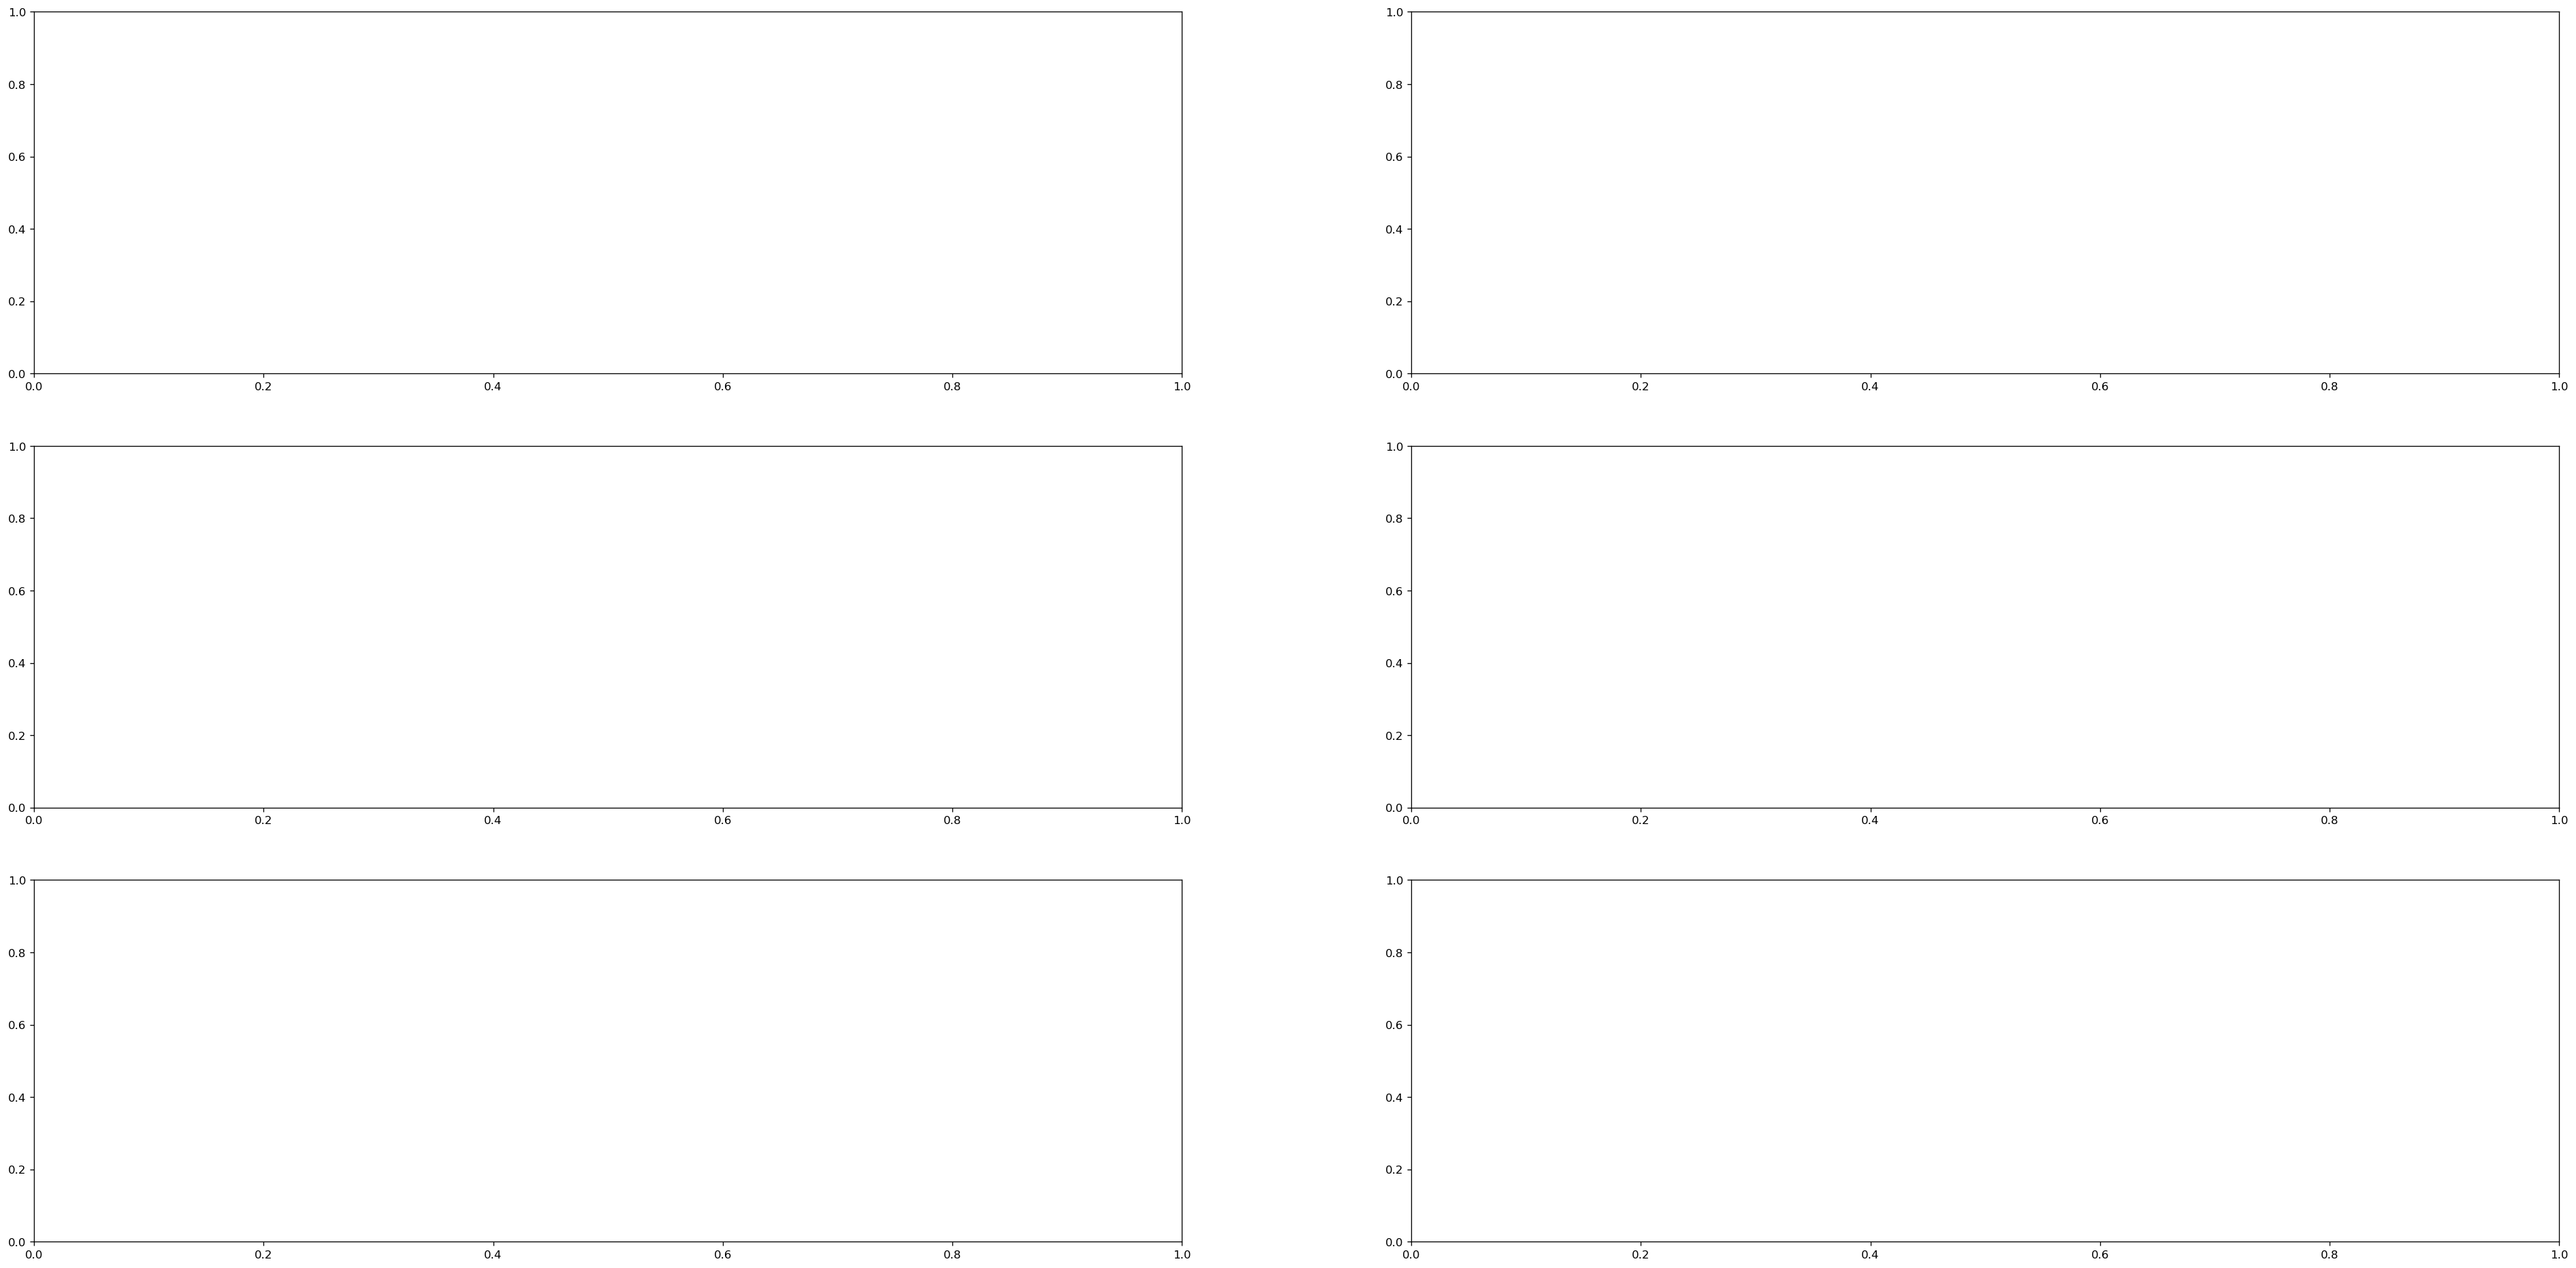

In [82]:
if args.opts.debug__save_figs:
    fig, axs = plt.subplots(
        nrows=3, ncols=2,
        figsize=(2 * (sz := 20), sz), 
        dpi=120,
    )

    viz_data = (
        data_volume[:, :, half_pad:-half_pad] 
        if args.model_type == Args.ModelType.input2halfd else 
        data_volume
    )

    display = viz.OrthogonalSlicesPredictionDisplay(
        volume_data=viz_data,
        volume_prediction=pred_volume,
        n_classes=n_classes,
        volume_name=volume.fullname + f".debug.predicted-volume.{idx=}",
    ).plot(axs=axs,)

    logger.info(f"Saving figure {(figname := display.title + '.png')=}")
    display.fig_.savefig(
        fname=figs_dir / figname,
        format="png",
        metadata=display.metadata,
    )       
    plt.close()

# Save

In [ ]:
logger.debug(f"Writing probabilities on disk at `{estimation_volume.probabilities_path}`")
np.save(estimation_volume.probabilities_path, proba_volume)

In [ ]:
if args.opts.save_probas_by_class:
    for klass_idx in volume.metadata.labels:
        logger.debug(f"Writing probabilities of class `{klass_idx}` on disk at `{(str_path := str(estimation_volume.get_class_probability_path(klass_idx)))=}`")
        file_utils.HST_write(proba_volume[:, :, :, klass_idx], str_path)

In [ ]:
logger.debug(f"Writing predictions on disk at `{(str_path := str(estimation_volume.predictions_path))}`")
file_utils.HST_write(pred_volume, str_path)

#### one-z-slice-crops-locations.png

not kept, search fro `one-z-slice-crops-locations.png` in `process-3d-crops-entire-2d-slice`

#### debug__materialize_crops

same for
`debug__materialize_crops`

# Save notebook

In [ ]:
this_nb_name = "process-volume-02.ipynb"
this_dir = os.getcwd()
save_nb_dir = str(estimation_volume.dir)

logger.warning(f"{this_nb_name=}")
logger.warning(f"{this_dir=}")
logger.warning(f"{save_nb_dir=}")

command = f"jupyter nbconvert {this_dir}/{this_nb_name} --output-dir {save_nb_dir} --to html"
os.system(command)